In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-05-14 03:15:35.033714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 03:15:36.103885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
df = pd.read_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed.csv')
train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]

In [6]:
df

,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded
0,2011-01-01 01:00:00,-0.557143,3,3,1
1,2011-01-01 02:00:00,-0.688278,3,3,1
2,2011-01-01 03:00:00,-0.784249,3,3,1
3,2011-01-01 04:00:00,-0.883150,3,3,1
4,2011-01-01 05:00:00,-0.900366,3,3,1
...,...,...,...,...,...
66492,2018-08-02 20:00:00,1.935897,2,1,1
66493,2018-08-02 21:00:00,1.625641,2,1,1
66494,2018-08-02 22:00:00,1.441026,2,3,1
66495,2018-08-02 23:00:00,1.207326,2,3,1


In [7]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train['COMED_MW_scaled'], order=(5, 0, 5), trend='n')

arima_result = arima_model.fit()
train_predictions = arima_result.predict(start=train.index[0], end=train.index[-1])
test_predictions = arima_result.predict(start=test.index[0], end=test.index[-1])

residuals = train['COMED_MW_scaled'] - train_predictions

/home/hashim/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Bayesian optimization to the tune the Hyperparameters 
Bayesian optimization is a sequential design strategy for optimizing complex, expensive, and noisy objective functions. Unlike grid search or random search, which sample hyperparameters without using past evaluations, Bayesian optimization builds a probabilistic model of the objective function and uses this model to make decisions about where to sample next. This approach is more efficient, especially when the objective function is expensive to evaluate.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np
def create_model(neurons=10, learning_rate=0.001): # create_model is a function that returns a compiled Keras model
    model = Sequential([ # create a Sequential model
        Dense(int(neurons), activation='relu', input_shape=(1,)), # add a Dense layer with ReLU activation and the input shape to the first layer
        Dense(1) # add a Dense layer with 1 unit
    ])
    optimizer = Adam(learning_rate=learning_rate) # create an Adam optimizer with the given learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer) # compile the model with mean squared error loss and the optimizer
    return model # return the model


def fit_model(neurons, learning_rate): # fit_model is a function that returns the mean cross-validated negative mean squared error
    model = KerasRegressor(model=create_model, model__neurons=neurons, model__learning_rate=learning_rate, epochs=3, batch_size=1, verbose=0) # create a KerasRegressor with the given parameters
    """
    batch_size: This is the number of samples that will be propagated through the network at once. 
    A batch size of 1 means that the model will be updated after each sample. 
    This is also known as online or stochastic training. 
    A larger batch size will mean that the model is updated less frequently, but the gradient estimate will be more accurate for each update.
    """
    print("Neurons: ", neurons, "Learning Rate: ", learning_rate) # print the current parameters
    return np.mean(cross_val_score(model, residuals[:-1].values.reshape(-1, 1), residuals[1:].values, cv=3, scoring='neg_mean_squared_error')) # return the mean cross-validated negative mean squared error

params_bounds = {'neurons': (5, 100), 'learning_rate': (1e-4, 1e-2)} # define the parameter bounds for Bayesian optimization

optimizer = BayesianOptimization(f=fit_model, pbounds=params_bounds, random_state=1) # create a BayesianOptimization object with the given parameters
optimizer.maximize(init_points=10, n_iter=25) # maximize the Bayesian optimization function with 10 initial points and 25 iterations

print("Best parameters: ", optimizer.max['params']) # print the best parameters


|   iter    |  target   | learni... |  neurons  |
-------------------------------------------------
Neurons:  73.43082687700502 Learning Rate:  0.004228517846555483


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 1         | -0.006067 | 0.004229  | 73.43     |
Neurons:  33.72159440002478 Learning Rate:  0.00010113231069171439


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 2         | -0.00598  | 0.0001011 | 33.72     |
Neurons:  13.772166503035791 Learning Rate:  0.0015528833190894193


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 3         | -0.006027 | 0.001553  | 13.77     |
Neurons:  37.82826906908954 Learning Rate:  0.0019439760926389421


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 4         | -0.006073 | 0.001944  | 37.83     |
Neurons:  56.18758973031891 Learning Rate:  0.004027997994883633


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 5         | -0.006037 | 0.004028  | 56.19     |
Neurons:  70.09585253769215 Learning Rate:  0.004250025692592619


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 6         | -0.00628  | 0.00425   | 70.1      |
Neurons:  88.42115645713982 Learning Rate:  0.0021240772723420225


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 7         | -0.00611  | 0.002124  | 88.42     |
Neurons:  68.69441346694822 Learning Rate:  0.00037113717265946903


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 8         | -0.00606  | 0.0003711 | 68.69     |
Neurons:  58.075533702346405 Learning Rate:  0.004231317543434558


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 9         | -0.006505 | 0.004231  | 58.08     |
Neurons:  23.819641463063483 Learning Rate:  0.0014898306920928144


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 10        | -0.006274 | 0.00149   | 23.82     |
Neurons:  40.04352114747633 Learning Rate:  0.001176885516151316


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 11        | -0.006008 | 0.001177  | 40.04     |
Neurons:  13.771152425665697 Learning Rate:  0.003952522879954832


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 12        | -0.006101 | 0.003953  | 13.77     |
Neurons:  40.03958560259669 Learning Rate:  0.00838599497870627


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 13        | -0.006264 | 0.008386  | 40.04     |
Neurons:  56.18761734834901 Learning Rate:  0.00913132130861917


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 14        | -0.006528 | 0.009131  | 56.19     |
Neurons:  13.774636655004022 Learning Rate:  0.004486586402928013


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 15        | -0.006336 | 0.004487  | 13.77     |
Neurons:  47.48402371323223 Learning Rate:  0.008888200607459438


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 16        | -0.006417 | 0.008888  | 47.48     |
Neurons:  38.44186399370188 Learning Rate:  0.004379712273009941


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 17        | -0.006159 | 0.00438   | 38.44     |
Neurons:  13.77157379535903 Learning Rate:  0.004323027654365508


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 18        | -0.006114 | 0.004323  | 13.77     |
Neurons:  71.69457894805348 Learning Rate:  0.005576692981776552


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 19        | -0.006229 | 0.005577  | 71.69     |
Neurons:  43.63494983220182 Learning Rate:  0.0015696039633532875


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 20        | -0.006176 | 0.00157   | 43.63     |
Neurons:  40.03940013489462 Learning Rate:  0.002587809469018713


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 21        | -0.005989 | 0.002588  | 40.04     |
Neurons:  73.43242518514913 Learning Rate:  0.0007332011358382065


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 22        | -0.006133 | 0.0007332 | 73.43     |
Neurons:  56.188711113252445 Learning Rate:  0.00023813597850821786


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 23        | -0.005957 | 0.0002381 | 56.19     |
Neurons:  13.76892006401865 Learning Rate:  0.0004390702656295506


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 24        | -0.005993 | 0.0004391 | 13.77     |
Neurons:  69.98990483384569 Learning Rate:  0.0017639565576671316


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 25        | -0.006007 | 0.001764  | 69.99     |
Neurons:  33.72448039274456 Learning Rate:  0.0034371712483840236


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 26        | -0.005995 | 0.003437  | 33.72     |
Neurons:  69.99163867963601 Learning Rate:  0.0071781583035584445


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 27        | -0.006897 | 0.007178  | 69.99     |
Neurons:  33.720226948746074 Learning Rate:  0.007337421682389617


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 28        | -0.006488 | 0.007337  | 33.72     |
Neurons:  84.11849277195154 Learning Rate:  0.0022728877322793287


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 29        | -0.005991 | 0.002273  | 84.12     |
Neurons:  40.045610872599575 Learning Rate:  0.00517085958174211


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 30        | -0.006223 | 0.005171  | 40.05     |
Neurons:  56.1852101422474 Learning Rate:  0.0014280444906818515


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 31        | -0.006057 | 0.001428  | 56.19     |
Neurons:  56.18808021822604 Learning Rate:  0.0027674371115148015


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 32        | -0.006063 | 0.002767  | 56.19     |
Neurons:  39.67375802208381 Learning Rate:  0.0002023955370501895


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 33        | -0.005959 | 0.0002024 | 39.67     |
Neurons:  51.35809002601099 Learning Rate:  0.004668280732744969


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 34        | -0.006134 | 0.004668  | 51.36     |
Neurons:  84.12232218242656 Learning Rate:  0.0013098368516530987


/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hashim/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

| 35        | -0.006031 | 0.00131   | 84.12     |
Best parameters:  {'learning_rate': 0.00023813597850821786, 'neurons': 56.188711113252445}


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

neurons =   56 # Number of neurons in the LSTM layer
learning_rate = 0.00023813597850821786  # Learning rate for the Adam optimizer

#What is the Adam optimizer?
#Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

model = Sequential([
    """
    LSTM layer with 'neurons' neurons and 'relu' activation function
    What does input)shape=(1, 1) mean?
    The input_shape parameter is a tuple that indicates the dimension of the input data. The input data is 1-dimensional, with 1 time step and 1 feature at each time step.
    What does Dense layer with 1 neuron mean?
    A Dense layer is a fully connected layer, meaning that each neuron in the layer is connected to every neuron in the previous layer. The Dense layer with 1 neuron is the output layer of the model, and it outputs a single value.
    """
    LSTM(neurons, activation='relu', input_shape=(1, 1)),  
    Dense(1) 
]) 

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1) # Stop training if the loss does not decrease for 5 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1) # Reduce the learning rate by a factor of 0.1 if the loss does not decrease for 3 consecutive epochs


model.fit(residuals[:-1].values.reshape(-1, 1, 1), residuals[1:].values,
          epochs=25, batch_size=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/25
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 41s 752us/step - loss: 0.0061 - learning_rate: 2.3814e-04
Epoch 2/25
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 40s 760us/step - loss: 0.0059 - learning_rate: 2.3814e-04
Epoch 3/25
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 37s 705us/step - loss: 0.0060 - learning_rate: 2.3814e-04
Epoch 4/25
53170/53196 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0060
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.381359809078276e-05.
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 38s 712us/step - loss: 0.0060 - learning_rate: 2.3814e-04
Epoch 5/25
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 38s 714us/step - loss: 0.0059 - learning_rate: 2.3814e-05
Epoch 6/25
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 37s 704us/step - loss: 0.0060 - learning_rate: 2.3814e-05
Epoch 7/25
53196/53196 ━━━━━━━━━━━━━━━━━━━━ 39s 735us/step - loss: 0.0059 - learning_rate: 2.3814e-05
Epoch 8/25
53185/53196 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0060
Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-05.
53196/53196 ━━━

In [20]:
# Predict corrections using the ANN on the ARIMA predictions for the test set
arima_resid = test['COMED_MW_scaled'] - test_predictions
corrections = model.predict(arima_resid.values.reshape(-1, 1))

# Apply corrections to the ARIMA predictions
final_predictions = test_predictions + corrections.flatten()

416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


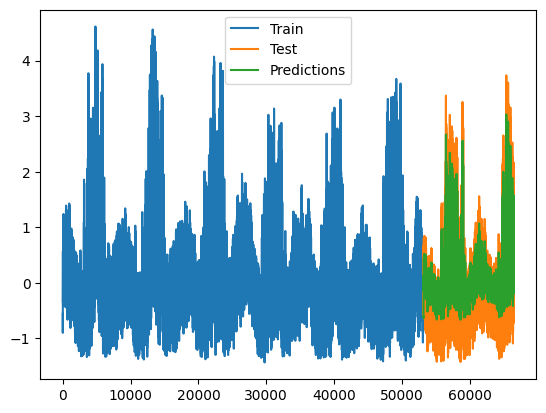

In [23]:
import matplotlib.pyplot as plt

plt.plot(train['COMED_MW_scaled'], label='Train')
plt.plot(test.index, test['COMED_MW_scaled'], label='Test')
plt.plot(test.index, -final_predictions, label='Predictions')
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

corrected_predictions = -final_predictions
actual_values = test['COMED_MW_scaled']

mse = mean_squared_error(actual_values, corrected_predictions)
mae = mean_absolute_error(actual_values, corrected_predictions)
r2 = r2_score(actual_values, corrected_predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")


Mean Squared Error: 0.14815176182685943
Mean Absolute Error: 0.32961990599984786
R2 Score: 0.7702275395331484


In [26]:
# Save a csv file with the results. The csv file should contain the folllwing columns: ,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded,Predictions. The predictions should start from the first row of the test data and continue to the end of the test data. The total number of rows should be equal to the length of the total data.
df['Predictions'] = np.nan
df.loc[test.index, 'Predictions'] = corrected_predictions
df.to_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/Hybrid_Predictions.csv', index=False)

In [27]:
# save the model 
model.save('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/ann_model.keras')

In [2]:
#load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/ann_model.keras')

2024-05-13 01:43:00.641435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 01:43:00.646616: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
